Build emulator for the SVD components of $\{ P_0(k | \theta_i) \}_{i \in LHD}$ 

In [1]:
import numpy as np 
import scipy as sp
import george as George
import nbodykit.lab as NBlab

# -- local -- 
import env
import lhd as LHD
import data as Dat
import compress as Cmprs
import forwardmodel as FM 

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Lets begin by reading in $\{\theta_i\}^{LHD}$s of the Latin Hypercube Design, which will be used to train the GP.

In [3]:
theta_lhd = LHD.HOD_LHD(HODrange='sinha2017prior_narrow', samples=40, method='mdu')
keylist = ['$\log\,M_{min}$', '$\sigma_{\log M}$', '$\log M_0$', '$\log M_1$', '\alpha']
print keylist
print theta_lhd[:5,:]
print theta_lhd.shape

['$\\log\\,M_{min}$', '$\\sigma_{\\log M}$', '$\\log M_0$', '$\\log M_1$', '\x07lpha']
[[ 11.725554   0.014474   8.357269  13.744437   1.245645]
 [ 11.046257   0.645123   9.217882  12.197783   1.003222]
 [ 11.626188   0.183786  10.483516  12.093106   1.158378]
 [ 11.891967   0.491157  12.775824  13.190476   0.968588]
 [ 12.074197   0.772377  10.988946  12.732762   0.779019]]
(40, 5)


Read in multiple realizations of $\{P(k|\theta_i)\}_{i\in LHD}$ 

In [9]:
pk_lhd = [] 
for ireal in range(1,11): 
    k_arr, pk_lhd_i = Dat.X_lhd(0.0, 1, 4, ireal, obvs='pk',
                          ell=0, Nmesh=360, rsd=True, krange=[0.01, 0.5], karr=True,
                          HODrange='sinha2017prior_narrow', samples=40, method='mdu', silent=True)
    if ireal == 1: 
        pk_lhd_i = np.concatenate([pk_lhd_i[:20,:], pk_lhd_i[21:,:]])
    pk_lhd.append(pk_lhd_i)
pk_lhd = np.mean(np.array(pk_lhd), axis=0)

21 of the LHD not read
21 of the LHD not read
21 of the LHD not read
21 of the LHD not read
21 of the LHD not read
21 of the LHD not read
21 of the LHD not read
21 of the LHD not read
21 of the LHD not read


Here's what $\{P(k|\theta_i)\}_{i\in LHD}$ look like

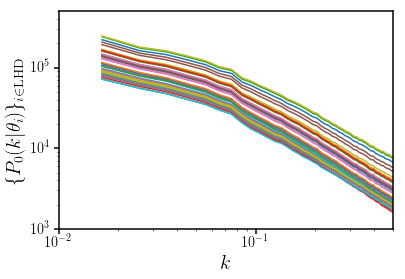

In [10]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_lhd.shape[0]): 
    sub.plot(k_arr, pk_lhd[i,:])
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel(r'$\{P_0(k|\theta_i)\}_{i \in \mathrm{LHD}}$', fontsize=20)
sub.set_ylim([10**3, 5e5])
sub.set_yscale('log')

Now lets construct $\{\theta_i\}^{test}$ which we will use for testing the accuracy of the GP.

In [ ]:
seed = 10
np.random.seed(seed)

In [ ]:
theta_test = np.zeros((10, theta_lhd.shape[1])) # 20 training parameter points
t_min = [11.4, 0.2, 9., 12.4, 0.7]
t_max = [11.8, 0.4, 12., 13., 1.3]

for i in range(theta_test.shape[1]): 
    ti = np.linspace(t_min[i], t_max[i], theta_test.shape[0])
    np.random.shuffle(ti)
    theta_test[:,i] = ti

In [ ]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(theta_lhd[:,0], theta_lhd[:,1], c='k')
sub.scatter(theta_test[:,0], theta_test[:,1])
sub.set_xlim([11.0, 12.2])
sub.set_xlabel(keylist[0], fontsize=20)
sub.set_ylim([0., 1.])
sub.set_ylabel(keylist[1], fontsize=20)

Construct $\{P(k|\theta_i)\}^{test}$

In [ ]:
def BigF(theta, halos): 
    # F(theta) --- i.e. the galaxy catalog generated
    # from the halo catalog
    p_hod = {'logMmin': theta[0], 'sigma_logM': theta[1], 'logM0': theta[2], 'logM1': theta[3], 'alpha': theta[4]}
    g = FM.Galaxies(halos, p_hod, seed=seed)
    g['RSDPosition'] = FM.RSD(g, LOS=[0,0,1]) # impose RSD
    return g

def ObvsBigF(bigf, obvs='p0k'):
    # measure P(k) from F(theta)
    plk_i = FM.Observables(bigf, observable='plk', Nmesh=360, rsd=True)
    klim = np.where((plk_i['k'] > 0.01) & (plk_i['k'] < 0.5))
    return plk_i['k'][klim], plk_i['p0k'][klim]

In [ ]:
# Read in halo catalog
halos = Dat.NeutHalos(0.0, 1, 4)

In [ ]:
pk_test = []
for i in range(theta_test.shape[0]): 
    gals_i = BigF(theta_test[i,:], halos)
    kk, p0k_i = ObvsBigF(gals_i, obvs='p0k')
    pk_test.append(p0k_i)
    if i == 0: karr = kk
pk_test = np.array(pk_test)

Here's what $\{P(k|\theta_i)\}_{test}$ look like

In [ ]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_test.shape[0]): 
    sub.plot(k_arr, pk_test[i,:])
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel(r'$\{P_0(k|\theta_i)\}_{i \in \mathrm{test}}$', fontsize=20)
sub.set_ylim([10**3, 5e5])
sub.set_yscale('log')

Get the SVD components of the LHD.

In [ ]:
n_comp = None
svd_lhd = Cmprs.Svd(n_comp=n_comp)
_ = svd_lhd.fit(pk_lhd)

In [ ]:
X_lhd = svd_lhd._white(pk_lhd)
X_test = svd_lhd._white(pk_test)

$\{P(k|\theta_i)\}_{i\in LHD}$ whitened by subtracting out the mean and scaling by the standard deviation

In [ ]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_lhd.shape[0]): 
    sub.plot(k_arr, X_lhd[i,:], c='k')
for i in range(pk_test.shape[0]): 
    sub.plot(k_arr, X_test[i,:])
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')

In [ ]:
pc_lhd = svd_lhd.transform(pk_lhd)

In [ ]:
pc_test = svd_lhd.transform(pk_test)

In [ ]:
# explained variance
print svd_lhd.exp_var_ratio[:n_comp]

Test SVD transformation

In [ ]:
pc_lhd_inv = svd_lhd.inv_transform(pc_lhd)
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pc_lhd.shape[0]): 
    sub.plot(k_arr, 1.-pc_lhd_inv[i,:]/pk_lhd[i,:])
sub.set_xlabel('$k$', fontsize=20)
sub.set_xscale('log')
sub.set_xlim([0.01,0.5])
sub.set_ylabel(r'$1 - \frac{P_0^{trans,trans}}{P_0^{LHD}}$', fontsize=20)
sub.set_ylim([-0.1, 0.1])
sub.set_title("SVD check")

In [ ]:
fig = plt.figure()
sub = fig.add_subplot(111)
_ = sub.hist(pc_lhd[:,0], normed=True) # LHD
_ = sub.hist(pc_test[:,0], normed=True) # test

In [ ]:
def trainGP(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    lguess = [(np.max(X[:,i]) - np.min(X[:,i]))/float(X.shape[0]) for i in range(X.shape[1])]

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess, ndim=X.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True)
        gp.compute(X)
        gps.append(gp)
    return gps


def trainGP_opt(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    lguess = [(np.max(X[:,i]) - np.min(X[:,i]))/float(X.shape[0]) for i in range(X.shape[1])]

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess, ndim=X.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True)
        gp.compute(X)
        # optimize hyperparameters
        p0 = gp.get_parameter_vector()
        results = sp.optimize.minimize(gp.nll, p0, args=(Y[:,i]), jac=gp.grad_nll, method='L-BFGS-B')
        gp.set_parameter_vector(results.x)
        gps.append(gp)
    return gps

def emu(x_pred, gps, Y): 
    # use GPs to predict Plk at x_pred
    mus, vs = [], [] 
    for i, gp in enumerate(gps): 
        mu, var = gp.predict(Y[:,i], x_pred)
        mus.append(mu)
        vs.append(var)
    return np.array(mus).T, np.array(vs).T

In [ ]:
# train Gaussian processes on the LHD
gp_emu = trainGP_opt(theta_lhd, pc_lhd)

In [ ]:
# now evaluate at the test points
pc_test_pred, var_test_pred = emu(theta_test, gp_emu, pc_lhd)

In [ ]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pc_test_pred.shape[0]): 
    sub.plot(range(pc_test_pred.shape[1]), 1.- pc_test_pred[i,:]/pc_test[i,:])
sub.set_xlabel('Component', fontsize=20)
sub.set_xlim([0., pc_test_pred.shape[1]])
sub.set_ylabel('$\mathrm{PC}^{test} - \mathrm{PC}^{GP,test}$', fontsize=20)
sub.set_ylim([-2., 2.])

In [ ]:
pk_test_pred = svd_lhd.inv_transform(pc_test_pred)

In [ ]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_test_pred.shape[0]): 
    sub.plot(karr, 1. - pk_test_pred[i,:]/pk_test[i,:])
sub.set_xlabel('$k$', fontsize=20)
sub.set_xscale('log')
sub.set_xlim([0.01,0.5])
sub.set_ylabel('$P_0^{test} - P_0^{GP,test}$', fontsize=20)

### Exclusion test
Train the GP on the LHD excluding one of the central $\theta_i$ and see how well it can predict $P_0(k|\theta_i)$

In [ ]:
inner = (theta_lhd[:,0] > t_min[0]) & (theta_lhd[:,0] < t_max[0])
for i in range(1, theta_lhd.shape[1]): 
    inner = inner & (theta_lhd[:,i] > t_min[i]) & (theta_lhd[:,i] < t_max[i])
print np.sum(inner)